In [15]:
import numpy as np
import sympy
import cirq
import tensorflow as tf
import tensorflow_quantum as tfq
import matplotlib.pyplot as plt

In [2]:
# Parameters that the classical NN will feed values into.
control_params = sympy.symbols('theta_1 theta_2 theta_3')

# Create the parameterized circuit.
qubit = cirq.GridQubit(0, 0)
model_circuit = cirq.Circuit(
    cirq.rz(control_params[0])(qubit),
    cirq.ry(control_params[1])(qubit),
    cirq.rx(control_params[2])(qubit))

In [3]:
model_circuit

(0, 0): ───Rz(theta_1)───Ry(theta_2)───Rx(theta_3)───

In [4]:
controller = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='elu'),
    tf.keras.layers.Dense(3)
])


In [6]:
circuits_input = tf.keras.Input(shape=(),
                                # The circuit-tensor has dtype `tf.string` 
                                dtype=tf.string,
                                name='circuits_input')

# Commands will be either `0` or `1`, specifying the state to set the qubit to.
commands_input = tf.keras.Input(shape=(1,),
                                dtype=tf.dtypes.float32,
                                name='commands_input')


dense_2 = controller(commands_input)

# TFQ layer for classically controlled circuits.
expectation_layer = tfq.layers.ControlledPQC(model_circuit,
                                             # Observe Z
                                             operators = cirq.Z(qubit))
expectation = expectation_layer([circuits_input, dense_2])


In [10]:
# The full Keras model is built from our layers.
model = tf.keras.Model(inputs=[circuits_input, commands_input],
                       outputs=expectation)

# The command input values to the classical NN.
commands = np.array([[0], [1]], dtype=np.float32)

# The desired Z expectation value at output of quantum circuit.
expected_outputs = np.array([[1], [-1]], dtype=np.float32)


random_rotations = np.random.uniform(0, 2 * np.pi, 3)
noisy_preparation = cirq.Circuit(
  cirq.rx(random_rotations[0])(qubit),
  cirq.ry(random_rotations[1])(qubit),
  cirq.rz(random_rotations[2])(qubit)
)
datapoint_circuits = tfq.convert_to_tensor([
  noisy_preparation
] * 2)  # Make two copied of this circuit


In [11]:
model([datapoint_circuits, commands]).numpy()


array([[ 0.03805751],
       [-0.25306913]], dtype=float32)

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)
history = model.fit(x=[datapoint_circuits, commands],
                    y=expected_outputs,
                    epochs=30,
                    verbose=1)


Train on 2 samples
Epoch 1/30
2/2 [==============================] - 1s 734ms/sample - loss: 0.7416
Epoch 2/30
2/2 [==============================] - 0s 2ms/sample - loss: 0.3585
Epoch 3/30
2/2 [==============================] - 0s 3ms/sample - loss: 0.2023
Epoch 4/30
2/2 [==============================] - 0s 2ms/sample - loss: 0.1269
Epoch 5/30
2/2 [==============================] - 0s 4ms/sample - loss: 0.0805
Epoch 6/30
2/2 [==============================] - 0s 2ms/sample - loss: 0.0369
Epoch 7/30
2/2 [==============================] - 0s 5ms/sample - loss: 0.0110
Epoch 8/30
2/2 [==============================] - 0s 2ms/sample - loss: 0.0026
Epoch 9/30
2/2 [==============================] - 0s 2ms/sample - loss: 0.0016
Epoch 10/30
2/2 [==============================] - 0s 4ms/sample - loss: 0.0028
Epoch 11/30
2/2 [==============================] - 0s 2ms/sample - loss: 0.0059
Epoch 12/30
2/2 [==============================] - 0s 5ms/sample - loss: 0.0105
Epoch 13/30
2/2 [===========

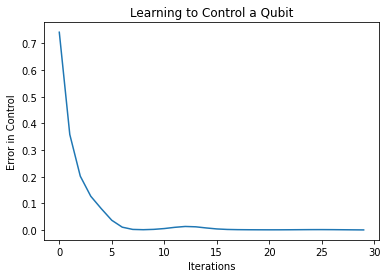

In [16]:
plt.plot(history.history['loss'])
plt.title("Learning to Control a Qubit")
plt.xlabel("Iterations")
plt.ylabel("Error in Control")
plt.show()


In [17]:
model([datapoint_circuits, commands])


<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[ 0.9711651],
       [-0.9826184]], dtype=float32)>

In [33]:
params=np.random.sample(3)
resolver = {k: v for k, v in zip(symbols, params)}
cirq.resolve_parameters(circuit,resolver)

(0, 0): ───Ry(0.222π)───

(0, 1): ───Ry(0.021π)───

(0, 2): ───Ry(0.029π)───

In [ ]:
circuit_input = tf.keras.Input(shape=(), dtype=tf.string)
output = tfq.layers.Expectation()(
        circuit_input,
        symbol_names=vansatz.symbols,
        operators=tfq.convert_to_tensor([observable]),
        initializer=tf.keras.initializers.RandomNormal())

output = tf.math.reduce_sum(output, axis=-1, keepdims=True)

model = tf.keras.Model(inputs=circuit_input, outputs=output)

In [35]:
expectation = tfq.layers.Expectation()
circuit_tensor = tfq.convert_to_tensor([circuit])
values_tensor = tf.convert_to_tensor(np.random.uniform(0, 2 * np.pi, (1, 3)).astype(np.float32))

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=0.01)

In [42]:
with tf.GradientTape() as g:
        g.watch(values_tensor)
        ex = expectation(circuit_tensor,
                    operators=tfq.convert_to_tensor([[op]]),
                    symbol_names=symbols,
                    symbol_values=values_tensor
                   )
        grads = g.gradient(ex, values_tensor)


In [44]:
grads

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[ 0.43461037, -0.00211143, -0.04018784]], dtype=float32)>

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.7763568e-15]], dtype=float32)>

In [196]:

class CirqSolver:
    def __init__(self, n_qubits=3, observable=None):
        self.name = "CirqSolver"
        self.n_qubits = n_qubits
        self.observable=observable #careful here!
        self.qubits = cirq.GridQubit.rect(1, n_qubits)
        self.alphabet = {"0":{"gate": cirq.X, "wires": [2]},
                            "1":{"gate": cirq.rz, "wires": [0]},
                            "2":{"gate": cirq.ry, "wires": [1]},
                            "3":{"gate": cirq.CNOT, "wires": [1,2]},#, "params":[np.pi]},
                            "4":{"gate": cirq.CNOT, "wires": [1,0]},#, "params":[np.pi]},
                            "5":{"gate": cirq.ry, "wires": [0]},
                            "6":{"gate":cirq.rz, "wires":[0]},#optimal sequence will be larger..
                            "7":{"gate": cirq.CNOT, "wires": [0,1]},#, "params":[np.pi]},
                           }

        self.parametrized = [cirq.rz, cirq.ry, cirq.rx]
        if observable is None:  # then take projector on W state
            sq = 1 / np.sqrt(3)
            w_state = np.array([0, sq, sq, 0, sq, 0, 0, 0])
            w_proj = cirq.density_matrix_from_state_vector(w_state)
            self.observable_matrix = w_proj
            self.observable = self.cirq_friendly_observable(w_proj)



    def cirq_friendly_observable(self, obs):
        PAULI_BASIS = {
            'I': np.eye(2),
            'X': np.array([[0., 1.], [1., 0.]]),
            'Y': np.array([[0., -1j], [1j, 0.]]),
            'Z': np.diag([1., -1]),
        }

        pauli3 = cirq.linalg.operator_spaces.kron_bases(PAULI_BASIS, repeat=3)
        decomp = cirq.linalg.operator_spaces.expand_matrix_in_orthogonal_basis(obs, pauli3) #notice it's not required to be orthonormal!

        PAULI_BASIS_CIRQ = {
            'I': cirq.X,
            'X': cirq.X,
            'Y': cirq.Y,
            'Z': cirq.Z,
        }

        unt = []
        for term in decomp.items():
            gate_name = term[0]
            coeff = term[1]
            s=0
            ot=float(coeff)
            for qpos, single_gate in enumerate(gate_name):
                if single_gate == "I":
                    ot*=PAULI_BASIS_CIRQ[single_gate](self.qubits[qpos])*PAULI_BASIS_CIRQ[single_gate](self.qubits[qpos])
                else:
                    ot*=PAULI_BASIS_CIRQ[single_gate](self.qubits[qpos])
            if s<3:
                unt.append(ot)
        return unt
    #
    #

    def vansatz_keras_model(self, vansatz, observable):
        #notice observable may in general be expressed as linear combination
        #of different elements  on orthonormal basis obtained from tensor product
        #of SU(2) generators. tf.math.reduce_sum is in charge of taking this linear combination.
        circuit_input = tf.keras.Input(shape=(), dtype=tf.string)
        output = tfq.layers.Expectation()(
                circuit_input,
                symbol_names=vansatz.symbols,
                operators=tfq.convert_to_tensor([observable]),
                initializer=tf.keras.initializers.RandomNormal())

        output = tf.math.reduce_sum(output, axis=-1, keepdims=True)

        model = tf.keras.Model(inputs=circuit_input, outputs=output)
        adam = tf.keras.optimizers.Adam(learning_rate=0.1)
        model.compile(optimizer=adam, loss='mse')
        return model

    def run_circuit(self, list_ops):
        wst = VAnsatz(list_ops)
        print(list_ops)
        if (wst.symbols == [])|(wst.cnots<1):
            simulator = cirq.Simulator()
            result = simulator.simulate(wst.get_state(self.qubits, params=np.random.sample(len(wst.symbols))), qubit_order=self.qubits)
            energy = np.trace(np.dot(wst.observable_matrix, cirq.density_matrix_from_state_vector(result.final_state))).real
            probs = np.abs(result.final_state)**2
            return energy, probs
        
        model = self.vansatz_keras_model(wst, self.observable)
        w_input = tfq.convert_to_tensor([wst.circuit])
        w_output = tf.ones((1,1)) #in case of W_state we want fidelity 1.
        print("estoy aquii")
        
        model.fit(x=w_input, y=w_output, batch_size=1, epochs=50,
                    verbose=0)
        energy = float(np.squeeze(model.predict(w_input)))

        simulator = cirq.Simulator()
        result = simulator.simulate(wst.get_state(self.qubits,params=model.get_weights()[0]), qubit_order=self.qubits)
        probs = np.abs(result.final_state)**2
        return energy, probs



class VAnsatz(CirqSolver):
    def __init__(self, trajectory):
        super(VAnsatz, self).__init__()
        self.cnots = 0
        param_ind=0
        gates=[]
        wires=[]
        params_cirquit=[]
        parhere=[]
        self.symbols=[]
        for gate_ind in trajectory:
            g = self.alphabet[str(int(gate_ind))]["gate"]
            wires.append(self.alphabet[str(int(gate_ind))]["wires"])
            if g in self.parametrized: #assuming is one qubit unitary
                symbol = "x_{}".format(param_ind)
                self.symbols.append(symbol)
                params_cirquit.append(sympy.Symbol(self.symbols[-1]))
                param_ind+=1
                gates.append(g(params_cirquit[-1]))
                parhere.append(True)
            else:
                if g == cirq.CNOT:
                    self.cnots+=1
                gates.append(g)
                parhere.append(False)
        self.wires = wires
        self._gates=gates
        self.parhere =parhere
        self.circuit=self.get_state(self.qubits)

    def get_state(self, qubits, params=None):
        circuit = cirq.Circuit()
        cc=[]
        for ind, g in enumerate(self._gates):
            if len(self.wires[ind])==1:
                indqub = self.wires[ind][0]
                cc.append(g(qubits[indqub]))
            else:
                control, target = self.wires[ind]
                cc.append(g(qubits[control], qubits[target]))
        circuit.append(cc)
        self.ac = cc
        if params is None:
            return circuit
        resolver = {k: v for k, v in zip(self.symbols, params)}
        return cirq.resolve_parameters(circuit, resolver)



print(solver.alphabet)


{'0': {'gate': cirq.X, 'wires': [2]}, '1': {'gate': <function rz at 0x7f4ed88869d8>, 'wires': [0]}, '2': {'gate': <function ry at 0x7f4ed88867b8>, 'wires': [1]}, '3': {'gate': cirq.CNOT, 'wires': [1, 2]}, '4': {'gate': cirq.CNOT, 'wires': [1, 0]}, '5': {'gate': <function ry at 0x7f4ed88867b8>, 'wires': [0]}, '6': {'gate': <function rz at 0x7f4ed88869d8>, 'wires': [0]}, '7': {'gate': cirq.CNOT, 'wires': [0, 1]}}


In [153]:
solver = CirqSolver()
print(solver.run_circuit(np.array([5.,4.])))

/home/cooper-cooper/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part


[5. 4.]
estoy aquii


InvalidArgumentError:  Found a Pauli sum operating on qubits not found in circuit.
	 [[node model_70/expectation_70/TfqSimulateExpectation (defined at <string>:69) ]] [Op:__inference_distributed_function_52361]

Errors may have originated from an input operation.
Input Source operations connected to node model_70/expectation_70/TfqSimulateExpectation:
 model_70/expectation_70/Const (defined at /home/cooper-cooper/.local/lib/python3.6/site-packages/tensorflow_quantum/python/layers/circuit_executors/input_checks.py:65)	
 IteratorGetNext (defined at <ipython-input-152-e8b90145c8b0>:104)	
 model_70/expectation_70/Tile_1 (defined at /home/cooper-cooper/.local/lib/python3.6/site-packages/tensorflow_quantum/python/layers/circuit_executors/expectation.py:288)	
 model_70/expectation_70/52198 (defined at /home/cooper-cooper/.local/lib/python3.6/site-packages/tensorflow_quantum/python/layers/circuit_executors/expectation.py:291)

Function call stack:
distributed_function


In [197]:
solver = CirqSolver()
print(solver.run_circuit(np.array([7,1])))

/home/cooper-cooper/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part


[7 1]
estoy aquii


InvalidArgumentError:  Found a Pauli sum operating on qubits not found in circuit.
	 [[{{node PartitionedCall/TfqSimulateExpectation}}]] [Op:__inference_distributed_function_61487]

Function call stack:
distributed_function


In [166]:
solver.alphabet

{'0': {'gate': cirq.X, 'wires': [2]},
 '1': {'gate': <function cirq.ops.common_gates.rz(rads:Union[float, sympy.core.basic.Basic]) -> cirq.ops.common_gates.ZPowGate>,
  'wires': [0]},
 '2': {'gate': <function cirq.ops.common_gates.ry(rads:Union[float, sympy.core.basic.Basic]) -> cirq.ops.common_gates.YPowGate>,
  'wires': [1]},
 '3': {'gate': cirq.CNOT, 'wires': [1, 2]},
 '4': {'gate': cirq.CNOT, 'wires': [1, 0]},
 '5': {'gate': <function cirq.ops.common_gates.ry(rads:Union[float, sympy.core.basic.Basic]) -> cirq.ops.common_gates.YPowGate>,
  'wires': [0]},
 '6': {'gate': <function cirq.ops.common_gates.rz(rads:Union[float, sympy.core.basic.Basic]) -> cirq.ops.common_gates.ZPowGate>,
  'wires': [0]},
 '7': {'gate': cirq.CNOT, 'wires': [0, 1]}}

In [163]:
t=np.array([5,4])
ww = VAnsatz(t)
ww.symbols

/home/cooper-cooper/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part


['x_0']

In [ ]:
ww.

In [164]:
ww.get_state(ww.qubits, np.random.sample(1))

(0, 0): ───Ry(0.142π)───X───
                        │
(0, 1): ────────────────@───

In [165]:
model = solver.vansatz_keras_model(ww, solver.observable)
w_input = tfq.convert_to_tensor([ww.circuit])
print(model(w_input), model.get_weights())
w_output = tf.ones((1,1)) #in case of W_state we want fidelity 1.
model.fit(x=w_input, y=w_output, batch_size=1, epochs=50,verbose=0)
print(model(w_input), model.get_weights())

InvalidArgumentError: Found a Pauli sum operating on qubits not found in circuit. [Op:TfqSimulateExpectation]

In [162]:
simulator = cirq.Simulator()
result = simulator.simulate(wst.get_state(ww.qubits,params=model.get_weights()[0]), qubit_order=ww.qubits)
result

measurements: (no measurements)
output vector: (0.991+0.132j)|000⟩